# Assignment 2: Global Temperature and Precipitation
Rosemary Knight (rknight@stanford.edu) & Seogi Kang (sgkang09@stanford.edu), Stanford Environmental Geophysics Group

This week, we will explore global temperature and precipitation, exploring how historical and recent changes may be similar or different. 

Data sets used this assignment are: 1) precipitation; 2) temperature. Here is a brief description of each:

1) Precipitation

Time period: 1985-2021

Temporal Resolution: Monthly

Spatial Extent: Global Land

Spatial Resolution: 1 degree

A reanalysis dataset is a dataset that blends observations and climate models in an attempt to produce the most complete and accurate map of historical and recent climate data. Our precipitation data come from the European Centre for Medium-Range Weather Forecasts, which combines their own models with data from satellites using active and passive microwave sensors. For more information see: https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation

2) Land Surface Temperature

Time Period: 1985-2021

Temporal Resolution: Monthly

Spatial Extent: Global Land

Spatial Resolution: 1 degree

The temperature data also come from the ERA5 dataset linked above, which again combines models with satellite data (and for temperature, ground-based observations are also used). Skin temperature is a term that describes the model's prediction of the what the temperature is at the earth's surface.


## Download required data and install Packages

In [ ]:
!pip install xarray numpy pandas geopandas cartopy==0.19.0.post1 ipywidgets 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip uninstall -y shapely

Found existing installation: Shapely 1.8.5.post1
Uninstalling Shapely-1.8.5.post1:
  Successfully uninstalled Shapely-1.8.5.post1


In [ ]:
!pip install shapely --no-binary shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached shapely-2.0.0.tar.gz (274 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/61/76/6e635cc4ba33e8c170ef5934dad5c269dc5cb9607e878efb2aba12f78361/shapely-2.0.0.tar.gz#sha256=11f1b1231a6c04213fb1226c6968d1b1b3b369ec42d1e9655066af87631860ea (from https://pypi.org/simple/shapely/) (requires-python:>=3.7): Requested unknown from https://files.pythonhosted.org/packages/61/76/6e635cc4ba33e8c170ef5934dad5c269dc5cb9607e878efb2aba12f78361/shapely-2.0.0.tar.gz#sha256=11f1b1231a6c04213fb1226c6968d1b1b3b369ec42d1e9655066af87631860ea has inconsistent name: filename has 'shapely', but metadata has 'unknown'
  Using cached Shapely-1.8.5.post1.tar.gz (200 kB)
  Installing build dependencies ... done
  Getting req

In [ ]:
!git clone https://premonition.stanford.edu/mmorphew/taking-the-pulse-global-data.git

fatal: destination path 'taking-the-pulse-global-data' already exists and is not an empty directory.


In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cf
import datetime
matplotlib.rcParams['font.size'] = 14

# Changes in Global Temperature and Precipitation

## IA Historical Temperature and Precipitation

Q: Calculate the trend in T and P globally in each individual grid cell and produce a map of globally gridded annual trends in each variable from 1985-2015. (Each cell will have one number, the slope from 1985-2021; color coded – red hotter and drier, blue – wetter and cooler) We will refer to these as the “historical trend maps.” What patterns do you observe? In other words, where are areas getting more(less) wet (dry) or hot (cool)? Pick two regions exhibiting either large increases or decreases in T or P. Based on what you know about these areas, are these patterns consistent with what you would expect due to predicted climate change dynamics and/or land-use?


In [ ]:
temp_precip_data = xr.load_dataset("./taking-the-pulse-global-data/global_precip_and_temp.nc")

In [ ]:
temp_precip_data

<xarray.Dataset>
Dimensions:              (time: 444, y: 180, x: 360)
Coordinates:
  * time                 (time) datetime64[ns] 1985-01-01 ... 2021-12-01
  * y                    (y) float64 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * x                    (x) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    skin_temperature     (time, y, x) float64 nan nan nan ... 244.5 244.5 244.5
    total_precipitation  (time, y, x) float64 nan nan ... 0.0003439 0.0003444
Attributes:
    transform:               [   1.    0. -180.    0.   -1.   90.]
    crs:                     +init=epsg:4326
    res:                     [1. 1.]
    is_tiled:                1
    nodatavals:              -32768.0
    scales:                  1.0
    offsets:                 0.0
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

In [ ]:
def linear_fit(time_series, data):
    # assume the time series has a regular sampling rate
    times = np.arange(len(time_series))
    G = np.c_[times, np.ones_like(times)]
    Pinv = np.linalg.pinv(G)
    m = Pinv.dot(data)
    predicted_data = G @ m
    slope = m[0,:]
    intercept = m[1,:]
    return predicted_data, slope, intercept

In [ ]:
temp_vec = temp_precip_data.skin_temperature.data.reshape((temp_precip_data.skin_temperature.data.shape[0], np.prod(temp_precip_data.skin_temperature.data.shape[1:])))
time_series = temp_precip_data.time.data
temp_linear_fit, slope, intercept = linear_fit(time_series, temp_vec)
temp_precip_data['temp_slope'] = (("y", "x"), slope.reshape(temp_precip_data.skin_temperature.data.shape[1:]))
temp_precip_data['temp_intercept'] = (("y", "x"), intercept.reshape(temp_precip_data.skin_temperature.data.shape[1:]))
temp_precip_data['temp_linear_fit'] = (("time", "y", "x"), temp_linear_fit.reshape(temp_precip_data.skin_temperature.data.shape))

In [ ]:
precip_vec = temp_precip_data.total_precipitation.data.reshape(
    (temp_precip_data.total_precipitation.data.shape[0], 
     np.prod(temp_precip_data.total_precipitation.data.shape[1:])))
time_series = temp_precip_data.time.data
precip_linear_fit, slope, intercept = linear_fit(time_series, precip_vec)
temp_precip_data['precip_slope'] = (("y", "x"), slope.reshape(temp_precip_data.total_precipitation.data.shape[1:]))
temp_precip_data['precip_intercept'] = (("y", "x"), intercept.reshape(temp_precip_data.total_precipitation.data.shape[1:]))
temp_precip_data['precip_linear_fit'] = (("time", "y", "x"), precip_linear_fit.reshape(temp_precip_data.total_precipitation.data.shape))

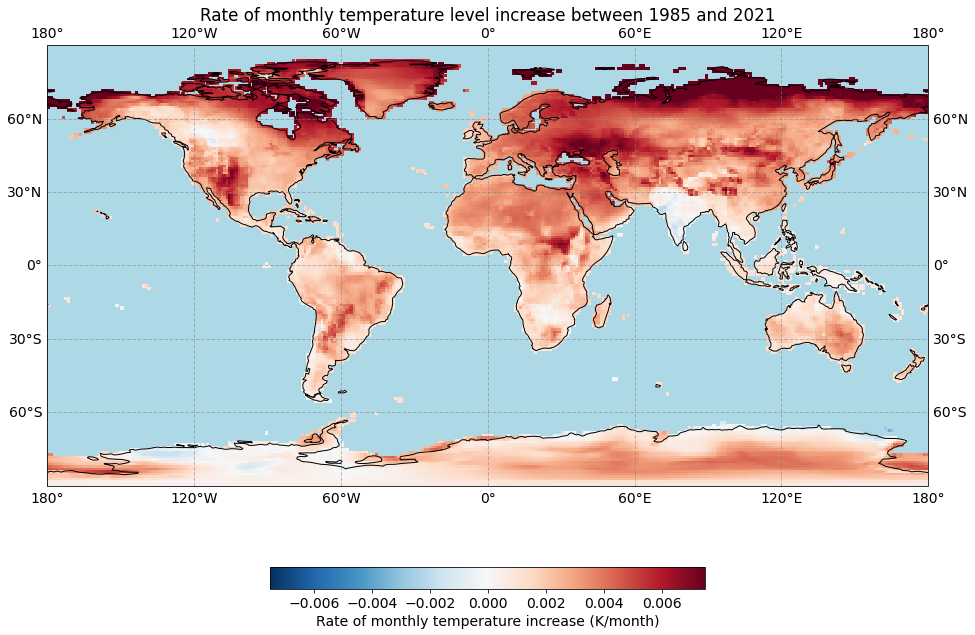

In [ ]:
fig = plt.figure(figsize=(20, 10))
i_time = 0

ax = plt.axes(projection=ccrs.PlateCarree())
ax.axes.add_feature(cf.COASTLINE)
# ax.axes.add_feature(cf.LAND);

out = temp_precip_data['temp_slope'].plot(ax=ax, add_colorbar=False, cmap='RdBu_r', vmax=0.0075)
cb = plt.colorbar(out, fraction=0.04, orientation='horizontal')
cb.set_label("Rate of monthly temperature increase (K/month)")
ax.set_aspect(1)
ax.set_facecolor('lightblue')
ax.set_title("Rate of monthly temperature level increase between 1985 and 2021")

gl = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True,
    linewidth=1, 
    color='gray', 
    alpha=0.5, 
    linestyle='--'
)

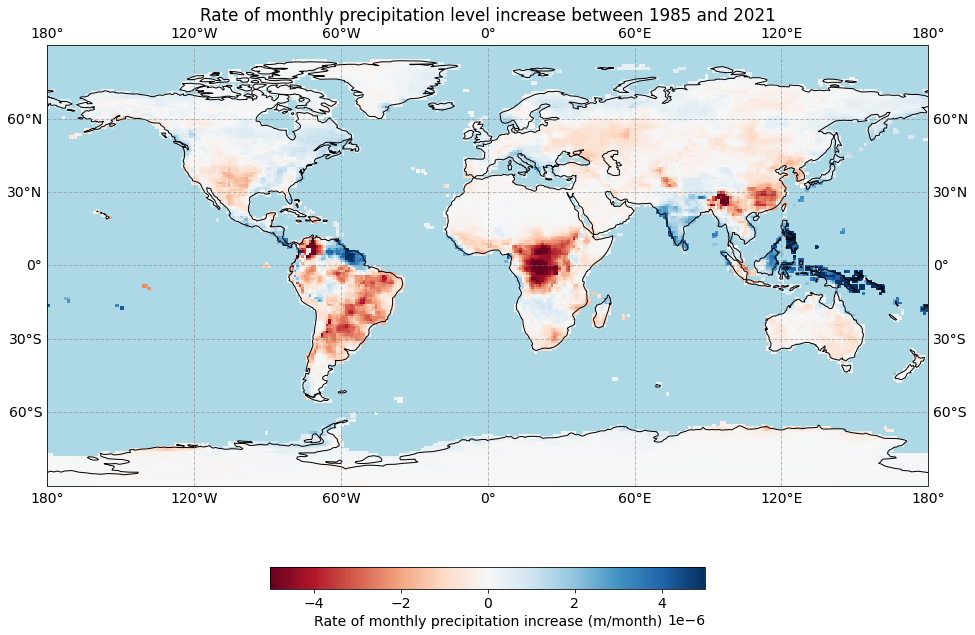

In [ ]:
fig = plt.figure(figsize=(20, 10))
i_time = 0

ax = plt.axes(projection=ccrs.PlateCarree())
ax.axes.add_feature(cf.COASTLINE)
# ax.axes.add_feature(cf.LAND);

out = temp_precip_data['precip_slope'].plot(ax=ax, add_colorbar=False, cmap='RdBu', vmin=-0.5e-5, vmax=0.5e-5)
cb = plt.colorbar(out, fraction=0.04, orientation='horizontal')
cb.set_label("Rate of monthly precipitation increase (m/month)")
ax.set_aspect(1)
ax.set_facecolor('lightblue')
ax.set_title("Rate of monthly precipitation level increase between 1985 and 2021")

gl = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True,
    linewidth=1, 
    color='gray', 
    alpha=0.5, 
    linestyle='--'
)

Q: Pick a few (3-4) years throughout 1985-2021, and produce two histograms, one histogram for temperature and one histogram for precipitation, for each year you selected. We recommend picking years that are spread apart. How are the histograms similar or different across the years? Why might the distributions be similar or different? Comment on the differences between using the trend maps and the single-year histograms to understand historical temperature and precipitation.

In [ ]:
### student code goes here

## IB Recent Temperature and Precipitation

### IB - Recent vs. Historical Trend Maps

Q:  Redo the temperature and precipitation trend maps but for 2003-2021, which we will call the “recent trend maps.” Compare and contrast the historical and recent trend maps.

In [ ]:
recent_temp_precip_data = temp_precip_data.sel(
    time=slice("2003-01-01", "2022-01-01"))
recent_temp_vec = recent_temp_precip_data.skin_temperature.data.reshape(
    (recent_temp_precip_data.skin_temperature.data.shape[0], 
     np.prod(recent_temp_precip_data.skin_temperature.data.shape[1:])))
recent_time_series = recent_temp_precip_data.time.data
recent_temp_linear_fit, slope, intercept = linear_fit(
    recent_time_series, recent_temp_vec)
recent_temp_precip_data['temp_slope'] = (("y", "x"), slope.reshape(
    recent_temp_precip_data.skin_temperature.data.shape[1:]))
recent_temp_precip_data['temp_intercept'] = (("y", "x"), intercept.reshape(
    recent_temp_precip_data.skin_temperature.data.shape[1:]))
recent_temp_precip_data['temp_linear_fit'] = (("time", "y", "x"), 
    recent_temp_linear_fit.reshape(
        recent_temp_precip_data.skin_temperature.data.shape))

In [ ]:
recent_precip_vec = recent_temp_precip_data.total_precipitation.data.reshape(
    (recent_temp_precip_data.total_precipitation.data.shape[0], 
     np.prod(recent_temp_precip_data.total_precipitation.data.shape[1:])))
recent_time_series = recent_temp_precip_data.time.data
recent_precip_linear_fit, slope, intercept = linear_fit(
    recent_time_series, recent_precip_vec)
recent_temp_precip_data['precip_slope'] = (("y", "x"), slope.reshape(
    recent_temp_precip_data.total_precipitation.data.shape[1:]))
recent_temp_precip_data['precip_intercept'] = (("y", "x"), intercept.reshape(
    recent_temp_precip_data.total_precipitation.data.shape[1:]))
recent_temp_precip_data['precip_linear_fit'] = (("time", "y", "x"), 
    recent_precip_linear_fit.reshape(
        recent_temp_precip_data.total_precipitation.data.shape))

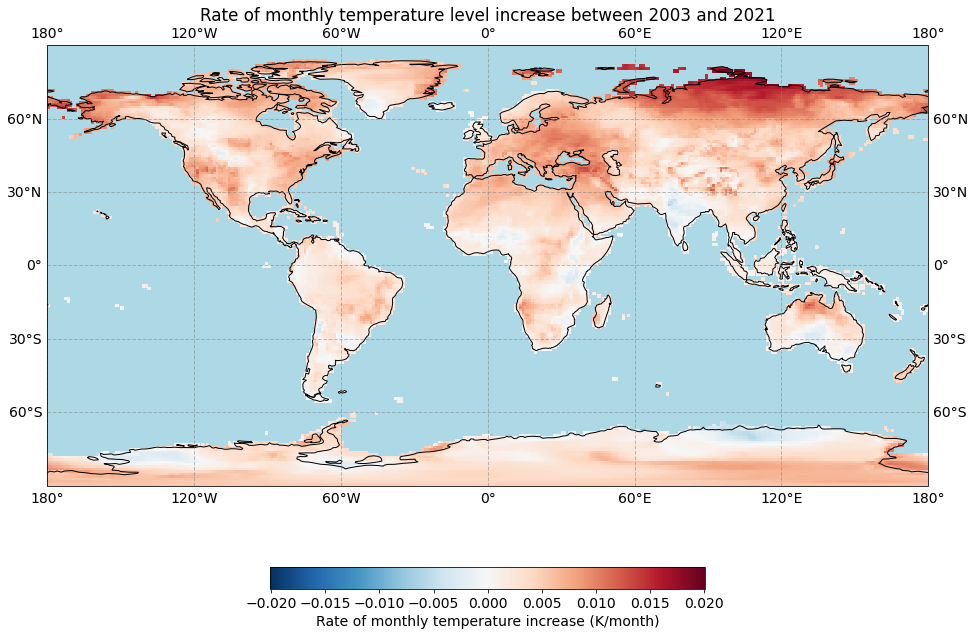

In [ ]:
fig = plt.figure(figsize=(20, 10))
i_time = 0

ax = plt.axes(projection=ccrs.PlateCarree())
ax.axes.add_feature(cf.COASTLINE)
# ax.axes.add_feature(cf.LAND);

out = recent_temp_precip_data['temp_slope'].plot(ax=ax, add_colorbar=False, cmap='RdBu_r')
cb = plt.colorbar(out, fraction=0.04, orientation='horizontal')
cb.set_label("Rate of monthly temperature increase (K/month)")
ax.set_aspect(1)
ax.set_facecolor('lightblue')
ax.set_title("Rate of monthly temperature level increase between 2003 and 2021")

gl = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True,
    linewidth=1, 
    color='gray', 
    alpha=0.5, 
    linestyle='--'
)

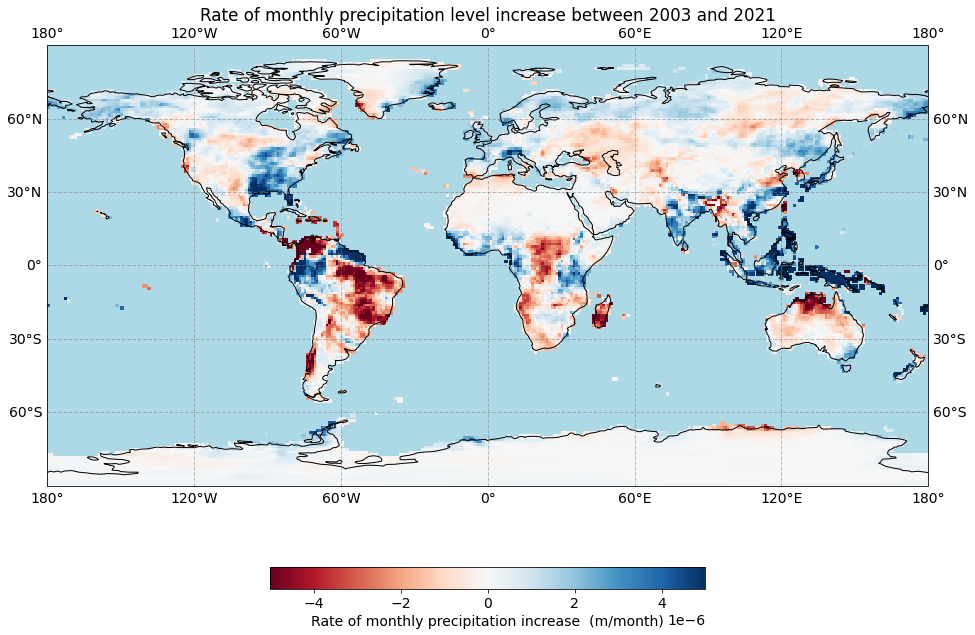

In [ ]:
fig = plt.figure(figsize=(20, 10))
i_time = 0

ax = plt.axes(projection=ccrs.PlateCarree())
ax.axes.add_feature(cf.COASTLINE)
# ax.axes.add_feature(cf.LAND);

out = recent_temp_precip_data['precip_slope'].plot(ax=ax, add_colorbar=False, cmap='RdBu', vmin=-0.5e-5, vmax=0.5e-5)
cb = plt.colorbar(out, fraction=0.04, orientation='horizontal')
cb.set_label("Rate of monthly precipitation increase  (m/month)")
ax.set_aspect(1)
ax.set_facecolor('lightblue')
ax.set_title("Rate of monthly precipitation level increase between 2003 and 2021")

gl = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True,
    linewidth=1, 
    color='gray', 
    alpha=0.5, 
    linestyle='--'
)

### IB - Recent vs. Historical Climatologies
Q: A “monthly climatology” calculates the average value of a variable for each month (e.g. the average of all January’s, average of all February’s, etc.) over a time period and allows us to consider the average monthly to seasonal variation in that variable. Calculate the monthly climatology for T and P for the full historical record and the recent record. Plot the T climatologies for the historical and recent periods in a single plot and repeat for the P climatologies in a single plot. Comment on the historical and recent climatologies for T and P separately. Is each variable experiencing similar variability between the two time periods? Are T and P exhibiting similar differences to one another between the time periods? How might climate change be impacting the differences between the historical and recent periods?

We can use x arrays "groupby" feature to group the data by month and then take the mean over time and space. This reduces our dataset to 12 points, each representing the global mean for each month. We can plot it as a bar chart to show the climatology for each variable.


In [ ]:
historical_temp_precip_monthly = temp_precip_data.groupby('time.month').mean().mean(['x','y'])
recent_temp_precip_monthly = recent_temp_precip_data.groupby('time.month').mean().mean(['x','y'])

Text(0.5, 1.0, 'Monthly Climatology: Temperature')

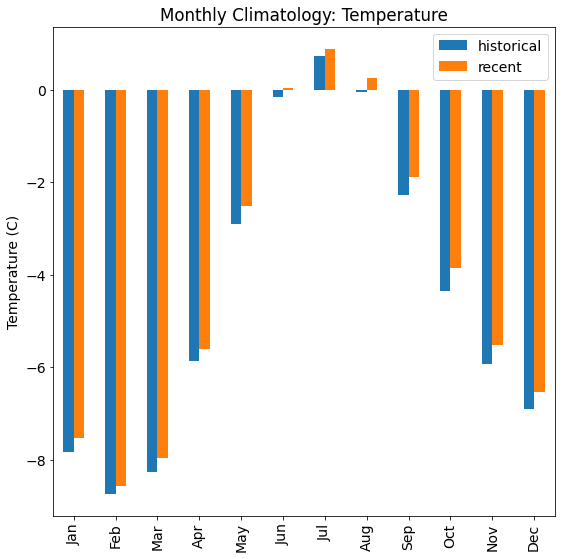

In [ ]:

fig, ax = plt.subplots(figsize=(9, 9))
series = historical_temp_precip_monthly.skin_temperature.to_numpy()-273.15
series2 = recent_temp_precip_monthly.skin_temperature.to_numpy()-273.15
index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 
                    'Sep', 'Oct', 'Nov', 'Dec']
combined_df = pd.DataFrame({'historical': series, 'recent': series2},
                           index=index)
combined_df.plot.bar(ax=ax)
ax.set_ylabel('Temperature (C)')
ax.set_xticklabels(('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 
                    'Sep', 'Oct', 'Nov', 'Dec'))
ax.set_title('Monthly Climatology: Temperature')


Text(0.5, 1.0, 'Monthly Climatology: Precipitation')

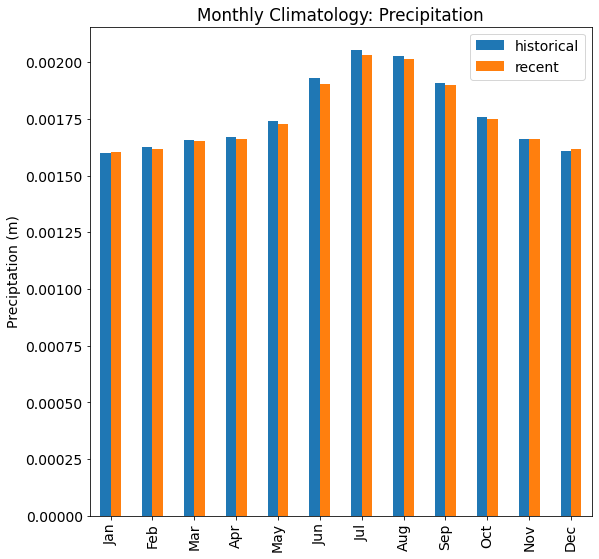

In [ ]:

fig, ax = plt.subplots(figsize=(9, 9))
series = historical_temp_precip_monthly.total_precipitation.to_numpy()
series2 = recent_temp_precip_monthly.total_precipitation.to_numpy()
index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 
                    'Sep', 'Oct', 'Nov', 'Dec']
combined_df = pd.DataFrame({'historical': series, 'recent': series2},
                           index=index)
combined_df.plot.bar(ax=ax)
ax.set_ylabel('Preciptation (m)')
ax.set_xticklabels(('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 
                    'Sep', 'Oct', 'Nov', 'Dec'))
ax.set_title('Monthly Climatology: Precipitation')